AUTOREGRESSIVE MOVING AVERAGE ARMA(P, Q) MODELS-PART III ARMA
===============================================

Ref: 
https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-3

ARMA(1,1)
-------

alpha1=0.5, beta1=-0.5

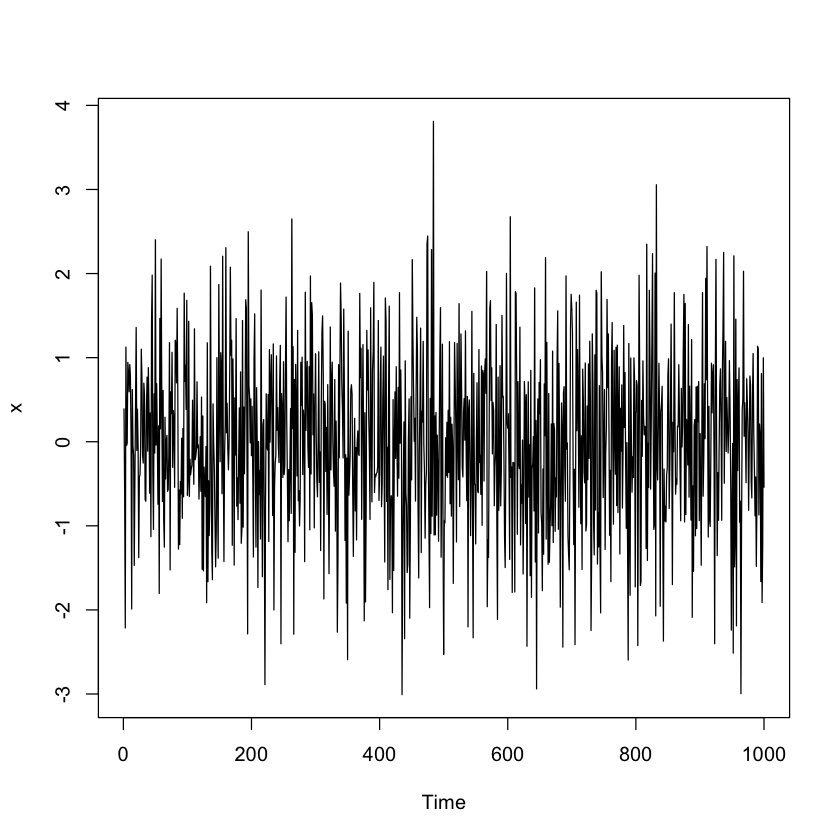

In [1]:
set.seed(1)
x <- arima.sim(n=1000, model=list(ar=0.5, ma=-0.5))
plot(x)

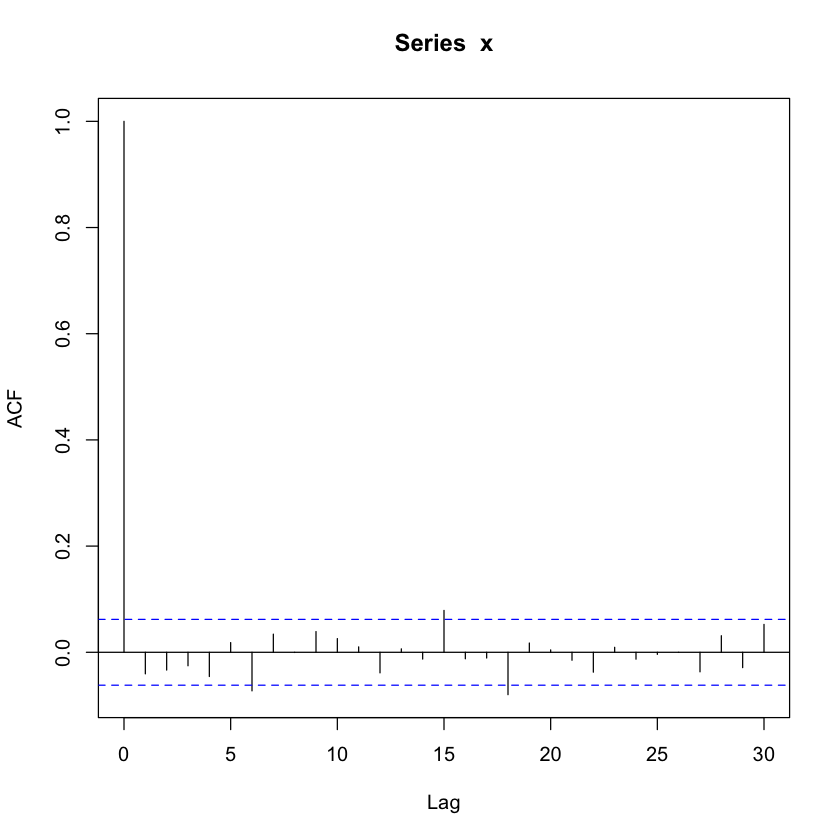

In [2]:
acf(x)

Determine the coefficients and their standard errors.

In [3]:
arima(x, order=c(1,0,1))


Call:
arima(x = x, order = c(1, 0, 1))

Coefficients:
         ar1      ma1  intercept
      0.6785  -0.7311    -0.0162
s.e.  0.1673   0.1550     0.0274

sigma^2 estimated as 1.07:  log likelihood = -1452.62,  aic = 2913.23

In [4]:
0.6785 + c(-1.96,1.96)*0.1673

[1] 0.350592 1.006408

In [5]:
-0.7311 + c(-1.96,1.96)*0.155

[1] -1.0349 -0.4273

The 95% CI do contain the true parameter values for both cases, however we should note that the 95% CI are very wide. 

ARMA(2,2)
---------

alpha1=0.5, alpha2=-0.25, beta1=0.5, beta2=-0.3

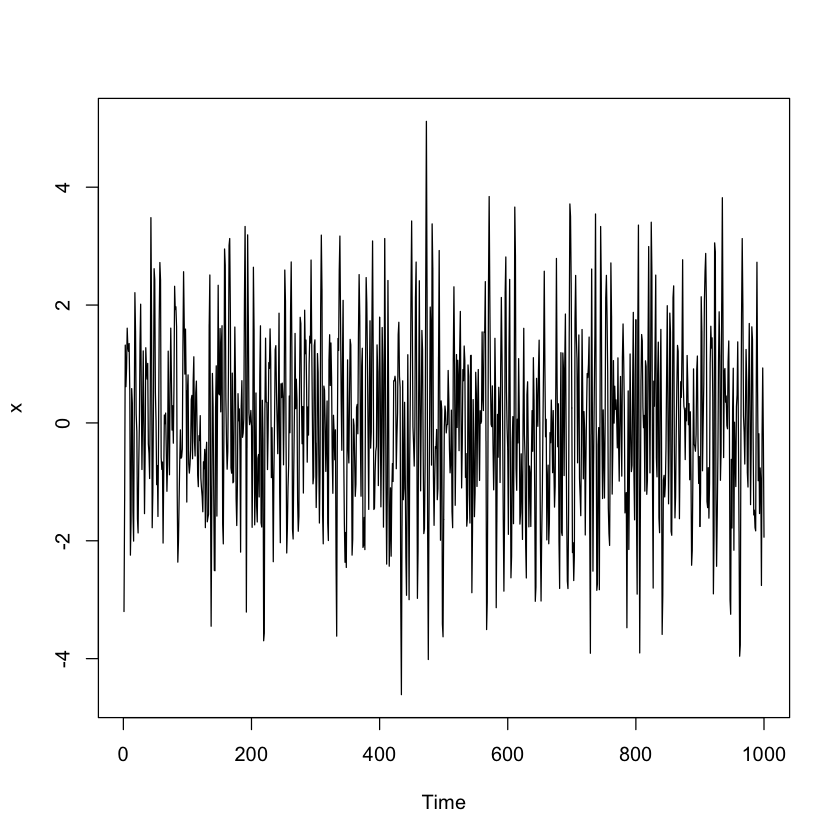

In [6]:
set.seed(1)
x <- arima.sim(n=1000, model=list(ar=c(0.5, -0.25), ma=c(0.5, -0.3)))
plot(x)

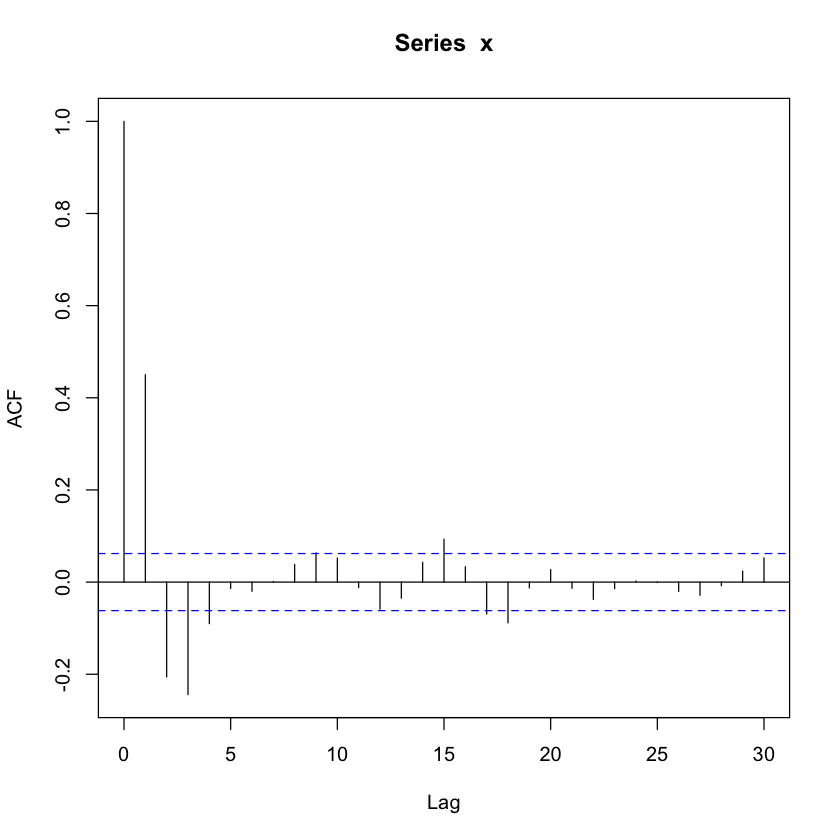

In [7]:
acf(x)

In [8]:
arima(x, order=c(2,0,2))


Call:
arima(x = x, order = c(2, 0, 2))

Coefficients:
         ar1      ar2     ma1      ma2  intercept
      0.6529  -0.2291  0.3191  -0.5522    -0.0290
s.e.  0.0802   0.0346  0.0792   0.0771     0.0434

sigma^2 estimated as 1.06:  log likelihood = -1449.16,  aic = 2910.32

In [9]:
0.6529 + c(-1.96,1.96)*0.08082

[1] 0.4944928 0.8113072

In [10]:
-0.2291 + c(-1.96,1.96)*0.0346

[1] -0.296916 -0.161284

In [11]:
0.3191 + c(-1.96,1.96)*0.0792

[1] 0.163868 0.474332

In [12]:
-0.5522 + c(-1.96,1.96)*0.0771

[1] -0.703316 -0.401084

Notice that the CIs for the coefficients for the moving average component (beta1 and beta2) do not actually contain the original parameter value. 
This outlines the danger of attempting to fit models to data, even when we know the true parameter values!

However, for trading purposes we just need to have a predictive power that exceeds chance and produces enough profit above transaction costs, in order to be profitable in the long run.

Choosing the Best ARMA(p,q) Model
--------------------------------
We need to use the **AIC** (or **BIC**) across a subset of values for p, q, and then apply the **Ljung-Box test** to determine if a good fit has been achieved, for particular values of p, q.

(1) Simulate a particular ARMA(p,q) process. 

(2) Loop over all pairwise values of p=[0:4] and q=[0:4] and caluculate the AIC.

(3) Select the model with the lowest AIC and then run the Ljung-Box test on the residuals to determine if we have achieved a good fit. 

Let's begin by stimulating an **ARMA(3,2)** series:

In [13]:
set.seed(3)
x <- arima.sim(n=1000, model=list(ar=c(0.5, -0.25, 0.4), ma=c(0.5, -0.3)))

We now create an object **final** to store the best model fit and lowest AIC value. We loop over various p, q combinations and use the **current** object to store the fit of an ARMA(i,j) model, for the looping variables i and j. 

If the current AIC < any previously calculated AIC, we set the final AIC to this current value and select that order. Upon termination of the loop we have the order of the ARMA model stored in **final.order** and the ARIMA(p,d,q) fit itself (with the "Integrated" d component set to 0) stored as **final.arma**: 

In [14]:
final.aic <- Inf
final.order <- c(0,0,0)
for (i in 0:4) for (j in 0:4){
    current.aic <-AIC(arima(x, order=c(i,0,j)))
    if (current.aic < final.aic){
        final.aic <- current.aic
        final.order <- c(i,0,j)
        final.arma <- arima(x, order=final.order)
    }
}

Warning message:
In arima(x, order = c(i, 0, j)): possible convergence problem: optim gave code = 1

In [15]:
final.aic

[1] 2863.365

In [16]:
final.order

[1] 3 0 2

In [17]:
final.arma


Call:
arima(x = x, order = final.order)

Coefficients:
         ar1      ar2     ar3     ma1      ma2  intercept
      0.4470  -0.2822  0.4079  0.5519  -0.2367     0.0274
s.e.  0.0867   0.0345  0.0309  0.0954   0.0905     0.0975

sigma^2 estimated as 1.009:  log likelihood = -1424.68,  aic = 2863.36

We can see that the orginal order of the simulated ARMA model was recovered. We can plot the correlogram of the residuals of the model to see if they look like a realisation of discrete white noise(DWN):

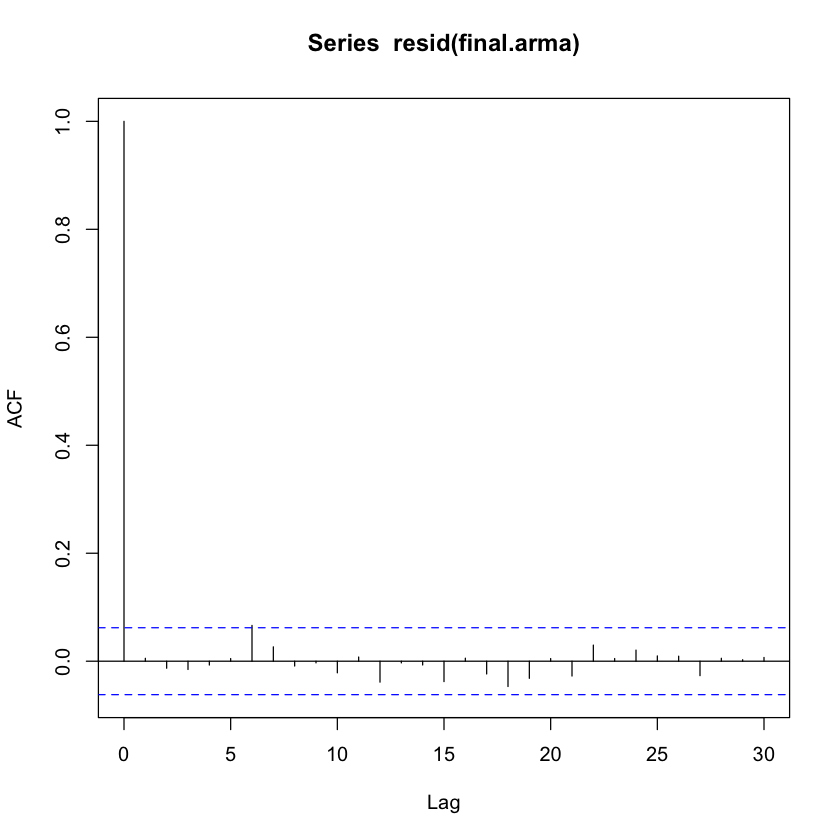

In [18]:
acf(resid(final.arma))

Perform the Ljung-Box test for 20 lags to confirm this:

In [19]:
Box.test(resid(final.arma), lag=20, type="Ljung-Box")


	Box-Ljung test

data:  resid(final.arma)
X-squared = 13.193, df = 20, p-value = 0.869


The p-value > 0.05, which states that the residuals are independent at the 95% and thus an ARMA(3,2) model provides a good model fit. 
Financial Data
-----------

In [21]:
library('TTR')
require('quantmod')
getSymbols("^GSPC",src='yahoo')
sp = diff(log(Cl(GSPC)))

Loading required package: quantmod
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Version 0.4-0 included new data defaults. See ?getSymbols.
    As of 0.4-0, ‘getSymbols’ uses env=parent.frame() and
 auto.assign=TRUE by default.

 This  behavior  will be  phased out in 0.5-0  when the call  will
 default to use auto.assign=FALSE. getOption("getSymbols.env") and 
 getOptions("getSymbols.auto.assign") are now checked for alternate defaults

 This message is shown once per session and may be disabled by setting 
 options("getSymbols.warning4.0"=FALSE). See ?getSymbols for more details.


[1] "GSPC"

In [22]:
spfinal.aic <- Inf
spfinal.order <- c(0,0,0)
for (i in 0:4) for (j in 0:4) {
    spcurrent.aic <- AIC(arima(sp, order=c(i,0,j)))
    if (spcurrent.aic < spfinal.aic){
        spfinal.aic <- spcurrent.aic
        spfinal.order <- c(i,0,j)
        spfinal.arma <- arima(sp, order=spfinal.order)
    }
}

Warning message:
In arima(sp, order = c(i, 0, j)): possible convergence problem: optim gave code = 1Warning message:
In arima(sp, order = spfinal.order): possible convergence problem: optim gave code = 1Warning message:
In arima(sp, order = c(i, 0, j)): possible convergence problem: optim gave code = 1

In [23]:
spfinal.order

[1] 3 0 3

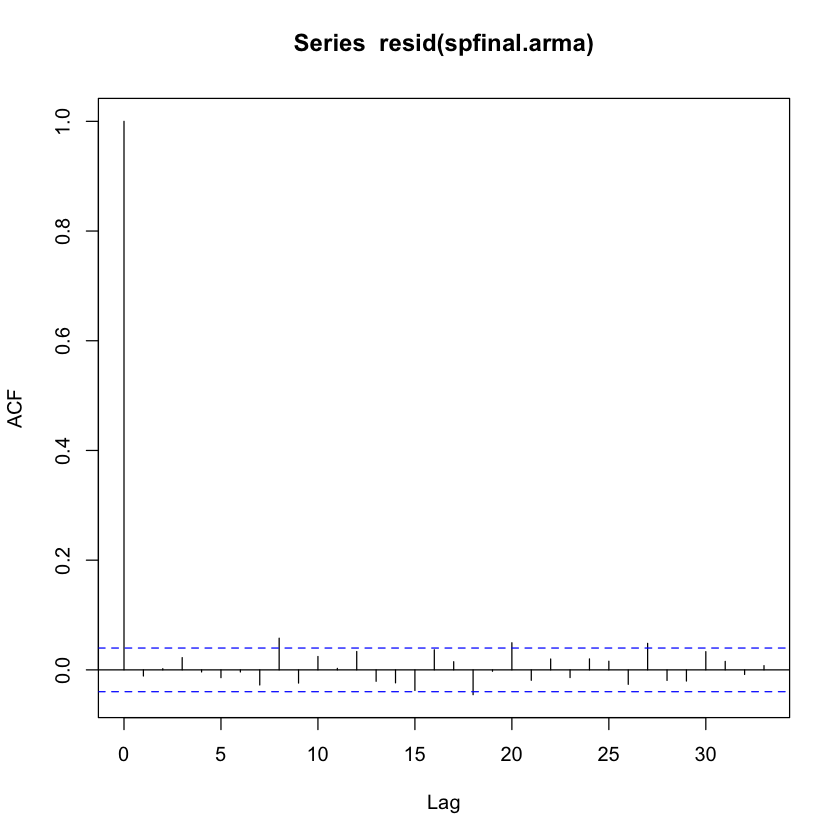

In [24]:
acf(resid(spfinal.arma),na.action=na.omit)

Notice that there are some significant peaks, especially at higher lags. This is indicative of a poor fit. Let's perform a Ljung-Box test to see if we have statistical evidence for it:

In [25]:
Box.test(resid(spfinal.arma), lag=20, type="Ljung-Box")


	Box-Ljung test

data:  resid(spfinal.arma)
X-squared = 38.307, df = 20, p-value = 0.00812


p-value < 0.05 so that we cannot say that the residuals are a realisation of discrete white noise. Hence there is additional autocorrelation in the residuals that is not explained by the fitted AR(3,3) model.

In practice, ARMA models are never generally good fits for log equities returns. We need to take into account the conditional heteroscedasticity and use a combination of ARIMA and GARCH.